In [1]:
# Set up environment
import logging
import os
import sys
import traceback
import time
import configparser
import pandas as pd
from pyspark.sql.functions import to_date

import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession

from psycopg2 import pool, DatabaseError
from pyspark.sql.functions import (
    col, when, lit, row_number, expr,
    min as F_min, max as F_max, datediff,
    lag, count, trim, mean as F_mean
)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql
from src.data_preprocessing.horse_recent_form_queries import form_sql_queries

# ------------------------------------------------
# 1) Basic logging
# ------------------------------------------------
def setup_logging(script_dir, log_file):
    """Sets up logging configuration to write logs to a file."""
    try:
        # Truncate the log file first
        with open(log_file, 'w'):
            pass

        logger = logging.getLogger()
        if logger.hasHandlers():
            logger.handlers.clear()

        logger.setLevel(logging.INFO)

        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(logging.INFO)

        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        logging.info("Logging initialized.")
    except Exception as e:
        print(f"Failed to set up logging: {e}", file=sys.stderr)
        sys.exit(1)

# ------------------------------------------------
# 2) Config + DB pool
# ------------------------------------------------
def read_config(script_dir, config_relative_path='../config.ini'):
    """Reads the configuration file and returns the configuration object."""
    try:
        config = configparser.ConfigParser()
        config_file_path = os.path.join(script_dir, config_relative_path)
        if not os.path.exists(config_file_path):
            raise FileNotFoundError(f"Configuration file '{config_file_path}' does not exist.")
        config.read(config_file_path)

        if 'database' not in config:
            raise KeyError("Missing 'database' section in the config file.")
        return config
    except Exception as e:
        logging.error(f"Error reading configuration file: {e}")
        sys.exit(1)

def get_db_pool(config):
    """Creates a connection pool to PostgreSQL."""
    try:
        db_pool_args = {
            'user': config['database']['user'],
            'host': config['database']['host'],
            'port': config['database']['port'],
            'database': config['database']['dbname']
        }
        password = config['database'].get('password')
        if password:
            db_pool_args['password'] = password
            logging.info("Using password authentication.")
        else:
            logging.info("No password in config; relying on .pgpass or other method.")

        db_pool = pool.SimpleConnectionPool(1, 10, **db_pool_args)
        if db_pool:
            logging.info("Connection pool created successfully.")
        return db_pool
    except DatabaseError as e:
        logging.error(f"Database error creating pool: {e}")
        sys.exit(1)
    except KeyError as e:
        logging.error(f"Missing config key: {e}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        sys.exit(1)


In [125]:
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # In a notebook, __file__ is not defined, so use the current working directory
    script_dir = os.getcwd()

config = read_config(script_dir)
log_file = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/logs/recent_form.log"
setup_logging(script_dir, log_file)

# Create DB pool (optional)
db_pool = get_db_pool(config)

# 1) Initialize your SparkSession and load data
spark, jdbc_url, jdbc_properties, parquet_dir, _ = initialize_environment()


Spark session created successfully.


In [3]:
conn = db_pool.getconn()
conn.autocommit = True
cursor = conn.cursor()

# Main Data Source

# GPS Composite Speed Figure

## 1. Establish a Baseline (“Par”) Performance
	
•	Separate by Key Factors:

>Break down historical data by the factors I believe influence times—distance, course type, and track condition. For each combination, **<u>compute the average seconds per meter</u>** (or, equivalently, a “par time”) that you expect a horse to run.

•	Plotting:

>Create scatter plots such as:

•	Distance vs. Seconds per Meter:
Plot each race’s seconds per meter for a given course and track condition. Then overlay the average (or even a regression line) to see how the “par” value evolves with distance.

•	Distance vs. Par Time:
For each distance, calculate the expected (or par) total time (i.e., distance * average seconds_per_meter) and plot that against the actual times. This lets you visually assess the deviations.

•	Regression Modeling:
Consider fitting a regression model where the dependent variable is the race time (or seconds per meter) and the independent variables are distance, track condition (possibly as categorical or as an index), and course. The model’s predictions can serve as your par time.



## **IMPORTANT:

Be sure to run this delete statemement before running query below

### Distance vs. Par Time/Seconds Per Meter

In [4]:
query = """
    SELECT
        c.course_cd,
        re.race_date,
        re.race_number,
        r.class_rating ,
        h.horse_id,
        re.horse_name,
        re.official_fin,
        s.dist_bk_gate4,
        s.total_distance_ran,
        s.running_time,
        c.track_name,
        tc.code,
        tc.description as trk_cond,
        r.distance_meters,
        AVG(r.rr_par_time) AS avg_time,
        AVG(r.rr_par_time) / r.distance_meters AS avg_sec_per_meter
    FROM races r
    JOIN results_entries re on r.course_cd = re.course_cd
        AND r.race_date = re.race_date
        AND r.race_number = re.race_number
    LEFT JOIN sectionals_aggregated s on re.course_cd = s.course_cd
        and re.race_date = s.race_date
        and re.race_number = s.race_number
        and re.program_num = s.saddle_cloth_number
    JOIN horse h on re.axciskey = h.axciskey
    JOIN track_conditions tc on r.trk_cond = tc.code
    JOIN course c on r.course_cd = c.course_cd
    WHERE r.rr_par_time is not null
    AND r.rr_par_time <> 0
    AND re.official_fin is not null
    AND re.official_fin <> 0
    --AND s.dist_bk_gate4 is not null
    --AND s.dist_bk_gate3 is not null
    AND r.class_rating > 60
    AND r.course_cd IN (
                    'CNL','SAR','PIM','TSA','BEL','MVR','TWO','CLS','KEE','TAM','TTP','TKD', 
                    'ELP','PEN','HOU','DMR','TLS','AQU','MTH','TGP','TGG','CBY','LRL', 
                    'TED','IND','CTD','ASD','TCD','LAD','TOP'
                    )
    GROUP BY c.course_cd,re.race_date,re.race_number, r.class_rating ,h.horse_id,re.horse_name,
        re.official_fin,s.dist_bk_gate4, s.total_distance_ran,s.running_time,c.track_name,
        tc.code,tc.description,r.distance_meters
    ORDER BY 2
    """
cursor.execute(query)

# Fetch all rows from the executed query
rows = cursor.fetchall()

# Extract column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame from the rows and column names
full_df = pd.DataFrame(rows, columns=columns)

# Display the DataFrame (in a notebook, just typing the variable will render it)
full_df

,course_cd,race_date,race_number,class_rating,horse_id,horse_name,official_fin,dist_bk_gate4,total_distance_ran,running_time,track_name,code,trk_cond,distance_meters,avg_time,avg_sec_per_meter
0,AQU,2022-01-01,1,97.00,4068,Nutzforboltz,6,NaN,NaN,NaN,AQUEDUCT,SY,sloppy,1810.512,113.57,0.062728
1,AQU,2022-01-01,1,97.00,7063,Battalion,1,NaN,NaN,NaN,AQUEDUCT,SY,sloppy,1810.512,113.57,0.062728
2,AQU,2022-01-01,1,97.00,11650,Noble Thought,5,NaN,NaN,NaN,AQUEDUCT,SY,sloppy,1810.512,113.57,0.062728
3,AQU,2022-01-01,1,97.00,11651,Runabout,3,NaN,NaN,NaN,AQUEDUCT,SY,sloppy,1810.512,113.57,0.062728
4,AQU,2022-01-01,1,97.00,21248,Flowers for Lisa,2,NaN,NaN,NaN,AQUEDUCT,SY,sloppy,1810.512,113.57,0.062728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401986,TTP,2025-02-13,10,76.00,434130,Laserjet,1,0.0,1620.8,100.96,TURFWAY PARK,FT,fast,1609.344,100.32,0.062336
401987,TTP,2025-02-13,10,76.00,457074,Golden Storm,4,21.1,1613.8,102.46,TURFWAY PARK,FT,fast,1609.344,100.32,0.062336
401988,TTP,2025-02-13,10,76.00,510858,Scoop,2,3.2,1613.8,101.21,TURFWAY PARK,FT,fast,1609.344,100.32,0.062336
401989,TTP,2025-02-13,10,76.00,580768,Run Run Rabbit,11,58.1,1624.1,104.99,TURFWAY PARK,FT,fast,1609.344,100.32,0.062336


In [5]:
full_df.count()

course_cd             401991
race_date             401991
race_number           401991
class_rating          401991
horse_id              401991
horse_name            401991
official_fin          401991
dist_bk_gate4         316284
total_distance_ran    320438
running_time          320438
track_name            401991
code                  401991
trk_cond              401991
distance_meters       401991
avg_time              401991
avg_sec_per_meter     401991
dtype: int64

# Drop Races with Missing Horses:

The heuristic requires that all horses in a race have these three fields:

        s.dist_bk_gate4,
        s.total_distance_ran,
        s.running_time,

In [6]:
import pandas as pd

# Define the race-identifying columns.
race_cols = ['course_cd', 'race_date', 'race_number']

# Define key sectional features to check for missing values.
key_features = ['dist_bk_gate4', 'total_distance_ran', 'running_time']
# If 'dist_bk_gate3' exists in your DataFrame, add it.
if 'dist_bk_gate3' in full_df.columns:
    key_features.append('dist_bk_gate3')

# Identify races with missing values in any of the key features.
# This returns a DataFrame with one row per race and a boolean flag.
races_missing_flag = (
    full_df.groupby(race_cols)[key_features]
           .apply(lambda grp: grp.isnull().any().any())
           .reset_index(name='has_missing')
)

# Display how many races have missing data.
num_races_total = races_missing_flag.shape[0]
num_races_with_missing = races_missing_flag[races_missing_flag['has_missing']].shape[0]
print(f"Total races: {num_races_total}")
print(f"Races with missing key features: {num_races_with_missing}")

# Merge back to the original DataFrame to filter out races with missing data.
# Only keep races where has_missing is False.
races_to_keep = races_missing_flag[races_missing_flag['has_missing'] == False][race_cols]
df_complete = full_df.merge(races_to_keep, on=race_cols, how='inner')

# Report how many horse entries (rows) are lost.
num_horses_before = len(full_df)
num_horses_after = len(df_complete)
num_horses_lost = num_horses_before - num_horses_after

print(f"Number of horse entries before dropping: {num_horses_before}")
print(f"Number of horse entries after dropping races with missing data: {num_horses_after}")
print(f"Number of horse entries lost: {num_horses_lost}")

# Optionally, you can replace full_df with the filtered dataset.
full_df = df_complete

Total races: 51738
Races with missing key features: 12641
Number of horse entries before dropping: 401991
Number of horse entries after dropping races with missing data: 304064
Number of horse entries lost: 97927


In [8]:
full_df.dtypes

course_cd              object
race_date              object
race_number             int64
class_rating           object
horse_id                int64
horse_name             object
official_fin            int64
dist_bk_gate4         float64
total_distance_ran    float64
running_time          float64
track_name             object
code                   object
trk_cond               object
distance_meters       float64
avg_time              float64
avg_sec_per_meter     float64
dtype: object

### NOTE: make sure race_date is changed to a date datatype

In [9]:
full_df['race_date'] = pd.to_datetime(full_df['race_date'])

### Class Multiplier

The class multiplier is designed to adjust a horse’s raw performance score by taking into account the quality of the race. We convert the race’s class rating (a measure of race quality) into a normalized value between 0 and 1. Then we scale that normalized value to range from 0 to 0.20 and add an offset of 0.95. As a result, **races with the lowest class rating receive a multiplier of 0.95, while races with the highest class rating receive a multiplier of 1.15.** This means that if two horses run similar raw speeds, the horse competing in a tougher (higher-class) race will have its performance boosted, while the performance in an easier (lower-class) race will be slightly discounted.


In [10]:
import numpy as np
import pandas as pd

# Convert the class_rating column to numeric
full_df['class_rating_numeric'] = pd.to_numeric(full_df['class_rating'], errors='coerce')

# Print summary statistics to see the range and median
class_min = full_df['class_rating_numeric'].min()
class_max = full_df['class_rating_numeric'].max()
class_median = full_df['class_rating_numeric'].median()

print("Class rating - min:", class_min, "max:", class_max, "median:", class_median)

# Create a class multiplier.
# For example, map the class ratings linearly to a multiplier range of 0.9 to 1.1.
# You can adjust these values if you want a different impact.
full_df['class_multiplier'] = 0.95 + (full_df['class_rating_numeric'] - class_min) * (1. - .95) / (class_max - class_min)

# Optionally, you might also compute a baseline offset:
full_df['class_offset'] = (full_df['class_rating_numeric'] - class_median)/2

print(full_df[['class_rating', 'class_rating_numeric', 'class_multiplier', 'class_offset']].head(5))

Class rating - min: 61.0 max: 123.0 median: 83.0
  class_rating  class_rating_numeric  class_multiplier  class_offset
0        76.00                  76.0          0.962097          -3.5
1        76.00                  76.0          0.962097          -3.5
2        76.00                  76.0          0.962097          -3.5
3        76.00                  76.0          0.962097          -3.5
4        76.00                  76.0          0.962097          -3.5


## Raw Performance Score


### Components

> OFFICIAL_DISTANCE

> BASE_SPEED

> WIDE_FACTOR

In [11]:
# Assume full_df already includes:
# 'distance_meters' (official distance),
# 'running_time' (the horse's running time),
# 'total_distance_ran' (actual distance run),
# 'class_rating_numeric' (the numeric class rating),
# and that you've computed class_min and class_max from your data.

# For clarity, rename official_distance to distance_meters.
full_df['official_distance'] = full_df['distance_meters']

# 1. Base Speed (in meters per second)
# Higher base_speed means faster.
full_df['base_speed'] = full_df['official_distance'] / full_df['running_time']

# 2. Running-Wide Adjustment
# If the horse ran extra distance, the factor is < 1.
full_df['wide_factor'] = full_df['official_distance'] / full_df['total_distance_ran']

# 3. (Already computed class_multiplier from class_rating_numeric above)
# 
# full_df['class_multiplier'] = 0.95 + (full_df['class_rating_numeric'] - class_min) * (1.1 - 0.90) / (class_max - class_min)

    

#### Par Time Differential (D):

First, compute the “par time” for a race as the average running_time among horses in that race (grouping by course, race_date, race_number, and track condition). Then, compute:

$$D = \frac{\text{par_time} - \text{running_time}}{\text{par_time}}$$

This figure is used to compare the horse to other horses that have run the same course, at the same distance, under similar track conditions.

In [12]:
# 4. Compute Par Time per race group.
group_cols = ['course_cd', 'race_date', 'race_number', 'trk_cond', 'official_distance']
full_df['par_time'] = full_df.groupby(group_cols)['running_time'].transform('mean')


### Par Differential Ratio

$$ par\_diff\_ratio = \frac{\text{par_time} - \text{running_time}}{\text{par_time}}$$

### Set the Tuning Parameter $$\alpha$$


In [114]:
# 5. Compute Par Time Differential Ratio.
# Positive if the horse ran faster than the race average.
full_df['par_diff_ratio'] = (full_df['par_time'] - full_df['running_time']) / full_df['par_time']

# 6. Set a tuning parameter for the effect of par differential.
alpha = 50  # Adjust this parameter as needed.


# Raw Performance Score

>How to Interpret This Score

•	Base Speed: Reflects the inherent speed over the official distance.

•	Wide Factor: Penalizes horses that run extra distance due to going wide.

•	Class Multiplier: Adjusts performance based on the quality of the race.

•	Par Differential: Rewards horses that run faster than the average for that race.

•	Raw Performance Score: The product of these factors, which should be higher for horses that:

•	Run faster (higher base_speed),

•	Run efficiently (wide_factor close to 1),

•	Compete in higher-class races (higher class_multiplier),

•	And beat the race average (positive par_diff_ratio).


In [115]:
# 7. Combine all components into a raw performance score.
full_df['raw_performance_score'] = ( full_df['base_speed'] *
                                     full_df['wide_factor'] *
                                     full_df['class_multiplier'] *
                                     (1 + alpha * full_df['par_diff_ratio']) )

# Penalty applied for dist_bk_gate4

full_df['dist_penalty'] = np.minimum(0.25 * full_df['dist_bk_gate4'], 10)
full_df['raw_performance_score'] = full_df['raw_performance_score'] - full_df['dist_penalty']

# Optional: Inspect the computed columns.
# print(full_df[['horse_id', 'official_fin', 'wide_factor', 
#                'class_multiplier', 'par_time', 'running_time', 'par_diff_ratio', 
#                'raw_performance_score', 'base_speed']].head(20))

# import pandas as pd

# # Define the target race details
# target_date = pd.Timestamp('2025-01-02')
# target_course = 'AQU'
# target_race_number = 3

# # Filter for the specific race
# selected_race = full_df[
#     (full_df['course_cd'] == target_course) &
#     (full_df['race_date'] == target_date) &
#     (full_df['race_number'] == target_race_number)
# ]

# # Display relevant columns
# print(selected_race[['horse_id', 'official_fin', 'raw_performance_score', 'base_speed', 'par_time', 'dist_bk_gate4']])

# Approach to Global Speed Score Calibration

>The key steps to achieving a 40-140 global speed figure with a Gaussian-like spread are:

1.	Normalize Raw Scores Across All Races

•	Your raw_performance_score likely has a range that varies depending on the race. You need to normalize it so that it is consistent across all races.

•	Compute a global mean and standard deviation across your dataset to standardize scores.

2.	Nonlinear Transformation (Gaussian Scaling)

•	Since raw scores might be skewed, we can normalize them into a Gaussian shape.

•	Using Z-score normalization, then mapping to a nonlinear function such as sigmoid or tanh, can help shape the distribution.

3.	Scale to the 40-140 Range

•	Once we have a normalized and transformed score, we scale it into the 40-140 range using a linear transformation.

### 1. Compute Global Normalization Parameters

In [116]:
import numpy as np

# Compute global mean and standard deviation for normalization
global_mean = full_df['raw_performance_score'].mean()
global_std = full_df['raw_performance_score'].std()

# Standardize the raw performance score (Z-score normalization)
full_df['standardized_score'] = (full_df['raw_performance_score'] - global_mean) / global_std

At this point, we have a Z-score, meaning most scores will be in the range of -3 to +3.

### 2. Apply a Nonlinear Transformation (Sigmoid or Tanh)

Since we want fewer extreme scores (approaching 40 and 140) and most horses clustering between 60 and 120, we apply a nonlinear transformation to the standardized score.

Sigmoid Transformation (Preferred for Gaussian-like distribution):

In [117]:
# tanh transformation
# tanh scales values between -1 and 1, preserving rank order while reducing extreme outliers.
full_df['normalized_score'] = np.tanh(full_df['standardized_score'])

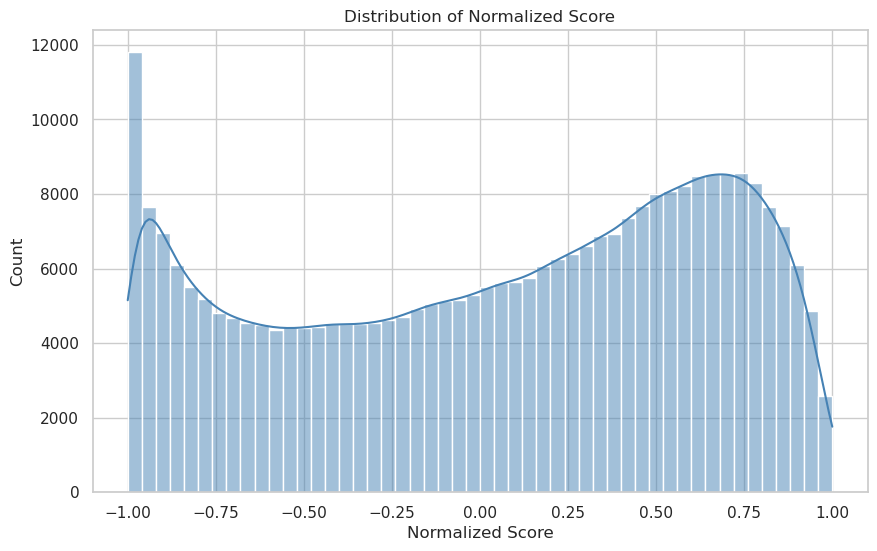

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a seaborn style
sns.set(style="whitegrid")

# 1. Histogram of Normalized Score
plt.figure(figsize=(10,6))
sns.histplot(full_df['normalized_score'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Normalized Score")
plt.xlabel("Normalized Score")
plt.ylabel("Count")
plt.show()


### 3. Scale to the 40-140 Range: Direct Gaussian Mapping

	•	Convert standardized scores to a percentile using scipy.stats.norm.cdf()
	•	Directly map percentiles to the 40-140 range

In [119]:
from scipy.stats import norm

# Convert standardized scores to percentiles
full_df['percentile_score'] = norm.cdf(full_df['standardized_score'])

# Scale percentiles to the 40-140 range
full_df['global_speed_score'] = 41 + (full_df['percentile_score'] * 97)

### 4. Verify the Distribution

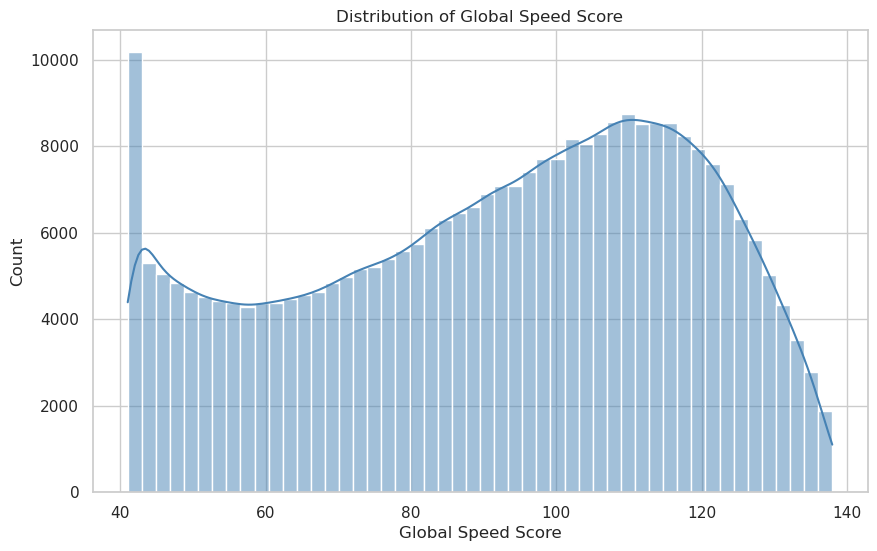

In [120]:
import matplotlib.pyplot as plt

# Set a seaborn style
sns.set(style="whitegrid")

# 1. Histogram of Global Speed Score
plt.figure(figsize=(10,6))
sns.histplot(full_df['global_speed_score'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Global Speed Score")
plt.xlabel("Global Speed Score")
plt.ylabel("Count")
plt.show()

## Disqualified Horses

In [121]:
# Ensure the horse_name column is available. 
# Filter rows where horse_name starts with "dq" (case-insensitive)
dq_horses = full_df[full_df['horse_name'].str.lower().str.startswith('dq')]

# Print the number of such entries
print("Number of horses with names starting with 'dq':", dq_horses.shape[0])

# Optionally, display a few rows for inspection
print(dq_horses[['horse_name', 'course_cd', 'race_date', 'race_number', 'official_fin']].head(10))

Number of horses with names starting with 'dq': 480
              horse_name course_cd  race_date  race_number  official_fin
708      dq-Smokin Class       PEN 2022-01-04            7             6
755             dq-Shyla       MVR 2022-01-05            7             4
1076          dq-Vintner       TAM 2022-01-07            7            10
3248    dq-Imperial Brew       TAM 2022-01-21            3             4
3628  dq-Brittle and Yoo       TGG 2022-01-22            7             4
4421   dq-Fancy Princess       LRL 2022-01-28            2             5
4704     dq-Hawkeye Girl       HOU 2022-01-29            5             4
5065          dq-Skywave       HOU 2022-01-30            1             6
6057    dq-Linda's Nekia       LRL 2022-02-06            6             8
6092      dq-Crystal Orb       TAM 2022-02-06            5             4


### Explanation
	
    1.	compute_match_percentage_adjusted Function:
	
    •	This function groups the data by the race keys (course_cd, race_date, race_number).
	
    •	It computes the official order (using official_fin, where a lower number is better) and the order based on your speed score (where a higher score is better).
	
    •	**It then computes the percentage of horses whose positions match between the two orderings.**
	
    •	The function returns a DataFrame (match_df) with one row per race, including the match percentage and the number of horses.
	
    2.	Identifying DQ Races:
	
    •	A boolean mask flags rows where the horse_name starts with “dq” (after converting to lowercase).
	
    •	Races that include at least one such horse are grouped and counted into dq_races.
	
    3.	Merging DQ Info with Match Percentages:
	
    •	The DQ race information is merged with match_df so you can compare match percentages between races with and without DQ horses.
	
    •	Races with a DQ count greater than 0 are separated from those with a count of 0.
	
    4.	Output:
	
    •	The code prints out the number of races with DQ horses.
	
    •	It provides descriptive statistics of match percentages for races with and without DQ horses.
	
    •	It also lists a sample of races with DQ horses that have less than 100% match.


In [122]:
import pandas as pd



Number of races that include at least one DQ horse: 477

Match percentage stats for races with DQ horses:
count    477.000000
mean      49.065880
std       23.220341
min        0.000000
25%       28.571429
50%       50.000000
75%       66.666667
max      100.000000
Name: match_percentage, dtype: float64

Match percentage stats for races without DQ horses:
count    38620.000000
mean        97.308874
std          8.342220
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: match_percentage, dtype: float64

Races with DQ horses and less than 100% match:
      course_cd  race_date  race_number  match_percentage  num_horses  \
6932        HOU 2024-03-29            6          0.000000          12   
23141       TGG 2023-01-08            7          0.000000           5   
33315       TSA 2023-06-16            1          0.000000           8   
9945        KEE 2024-04-21            1          0.000000           6   
12358       LR

In [123]:
# Exclude races that include a DQ horse
non_dq_race_keys = match_with_dq[match_with_dq['dq_count'] == 0][race_cols]
non_dq_df = full_df.merge(non_dq_race_keys, on=race_cols, how='inner')

# Compute match percentage for non-DQ races
match_non_dq_df = compute_match_percentage_adjusted(non_dq_df, race_cols, speed_col='global_speed_score')
print("Match percentage stats for races without DQ horses:")
print(match_non_dq_df['match_percentage'].describe())

Match percentage stats for races without DQ horses:
count    38620.000000
mean        97.308874
std          8.342220
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: match_percentage, dtype: float64


In [124]:
import pandas as pd

# Define the race-identifying columns.
race_cols = ['course_cd', 'race_date', 'race_number']

# Identify races with at least one horse whose name starts with "dh" or "dq" (case-insensitive)
excluded_mask = full_df['horse_name'].str.lower().str.startswith('dh') | full_df['horse_name'].str.lower().str.startswith('dq')
races_to_exclude = full_df[excluded_mask].groupby(race_cols).size().reset_index()[race_cols]
print("Number of races to exclude due to horse names starting with 'dh' or 'dq':", races_to_exclude.shape[0])

# Now exclude those races from your dataset
# Perform an anti-join: keep only rows in full_df whose race key is NOT in races_to_exclude
complete_races = full_df.merge(races_to_exclude, on=race_cols, how='left', indicator=True)
filtered_df = complete_races[complete_races['_merge'] == 'left_only'].drop(columns=['_merge'])

# Report the numbers after filtering
total_races_filtered = filtered_df[race_cols].drop_duplicates().shape[0]
total_horses_filtered = len(filtered_df)
print("Total races after excluding DQ/DH races:", total_races_filtered)
print("Total horse entries after excluding DQ/DH races:", total_horses_filtered)

# Now recompute the match percentage on the filtered dataset.
match_filtered_df = compute_match_percentage_adjusted(filtered_df, race_cols, speed_col='global_speed_score')
print("\nMatch percentage summary for races without DQ/DH horses:")
print(match_filtered_df['match_percentage'].describe())

Number of races to exclude due to horse names starting with 'dh' or 'dq': 1028
Total races after excluding DQ/DH races: 38069
Total horse entries after excluding DQ/DH races: 295327

Match percentage summary for races without DQ/DH horses:
count    38069.000000
mean        97.476108
std          8.088684
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: match_percentage, dtype: float64


In [69]:
# Identify races (from the filtered data) with less than 100% match percentage.
mismatched_races_info = match_filtered_df[match_filtered_df['match_percentage'] < 100].copy()

if not mismatched_races_info.empty:
    # Sort by match percentage ascending so the worst-matching races are at the top.
    mismatched_races_info = mismatched_races_info.sort_values('match_percentage')
    
    # Display key race information.
    print("Races with mismatches (match_percentage < 100):")
    print(mismatched_races_info[['course_cd', 'race_date', 'race_number', 'match_percentage', 'num_horses']].to_string(index=False))
else:
    print("All races have a perfect match (100%)!")

Races with mismatches (match_percentage < 100):
course_cd  race_date  race_number  match_percentage  num_horses
      ASD 2024-09-24            4          0.000000           6
      TAM 2024-11-29            4         11.111111           9
      TLS 2022-11-05            3         12.500000           8
      TLS 2022-11-18            4         14.285714           7
      TAM 2024-11-29            2         14.285714           7
      TSA 2024-04-04            4         14.285714           7
      TGP 2025-02-05            6         16.666667           6
      TGP 2024-05-30            6         16.666667           6
      CBY 2022-09-14            5         16.666667           6
      LRL 2022-05-07           10         20.000000           5
      TGP 2022-11-26            6         20.000000          10
      TGP 2024-03-14            3         20.000000           5
      DMR 2022-11-26            2         20.000000           5
      MVR 2022-01-14            3         20.000000     

In [45]:
full_df.dtypes

course_cd                        object
race_date                datetime64[ns]
race_number                       int64
class_rating                     object
horse_id                          int64
horse_name                       object
official_fin                      int64
dist_bk_gate4                   float64
total_distance_ran              float64
running_time                    float64
track_name                       object
code                             object
trk_cond                         object
distance_meters                 float64
avg_time                        float64
avg_sec_per_meter               float64
class_rating_numeric            float64
class_multiplier                float64
class_offset                    float64
official_distance               float64
base_speed                      float64
wide_factor                     float64
par_time                        float64
par_diff_ratio                  float64
raw_performance_score           float64


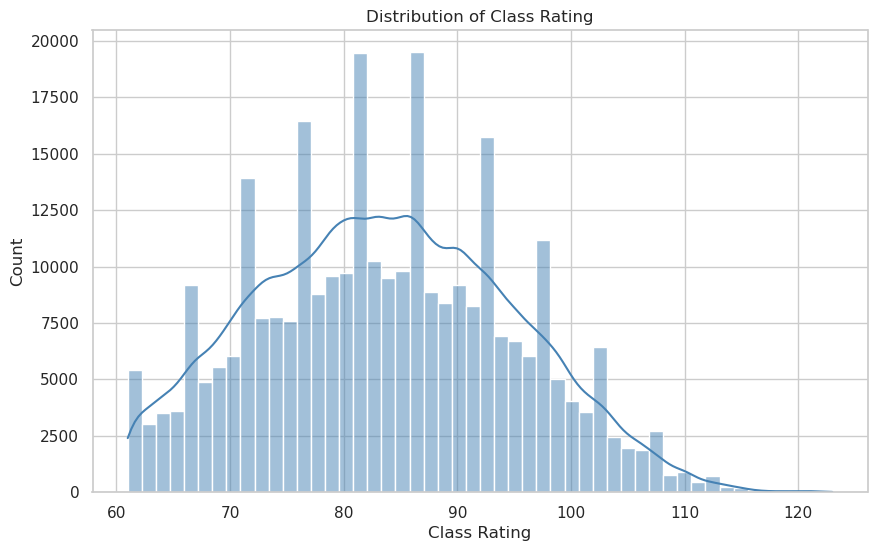

In [26]:
import matplotlib.pyplot as plt

# Set a seaborn style
sns.set(style="whitegrid")

# 1. Histogram of Class Rating
plt.figure(figsize=(10,6))
sns.histplot(full_df['class_rating'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Class Rating")
plt.xlabel("Class Rating")
plt.ylabel("Count")
plt.show()

# Global Speed Figure Interperability:


> Histogram and Boxplot:

Identify any skew or outliers in the speed score distribution and see if certain courses consistently yield higher or lower scores.

> Scatter Plots:

Reveal any non-linear relationships or clusters between your computed metrics (global speed score and raw performance score) and race outcomes (official finish or distance behind gate).
	
> Match Percentage Distribution:

Show how well your speed figure is matching the official finish order across races. If there are many races with lower match percentages, you may want to investigate further.

> Time Series:

Uncover any trends or shifts in average performance over time—perhaps related to seasonal changes, improvements in data quality, or changes in race conditions.


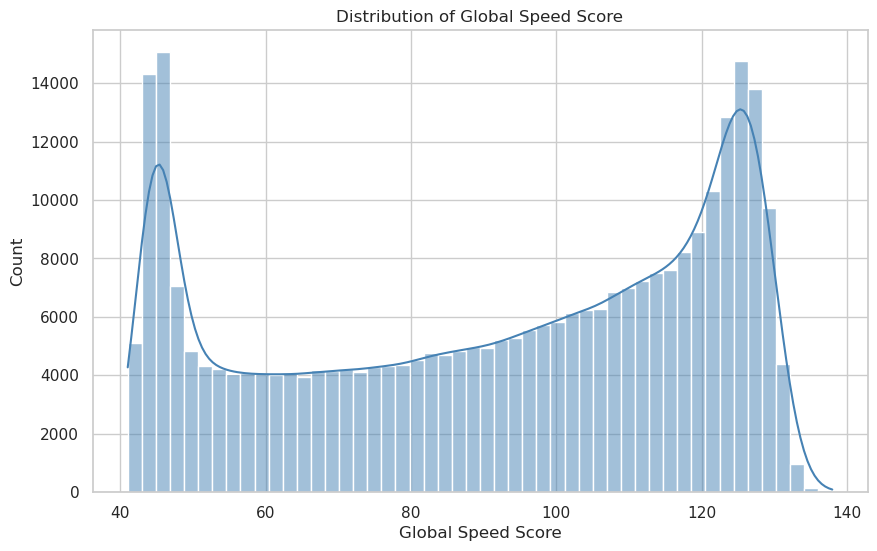

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a seaborn style
sns.set(style="whitegrid")

# 1. Histogram of Global Speed Score
plt.figure(figsize=(10,6))
sns.histplot(full_df['global_speed_score'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Global Speed Score")
plt.xlabel("Global Speed Score")
plt.ylabel("Count")
plt.show()


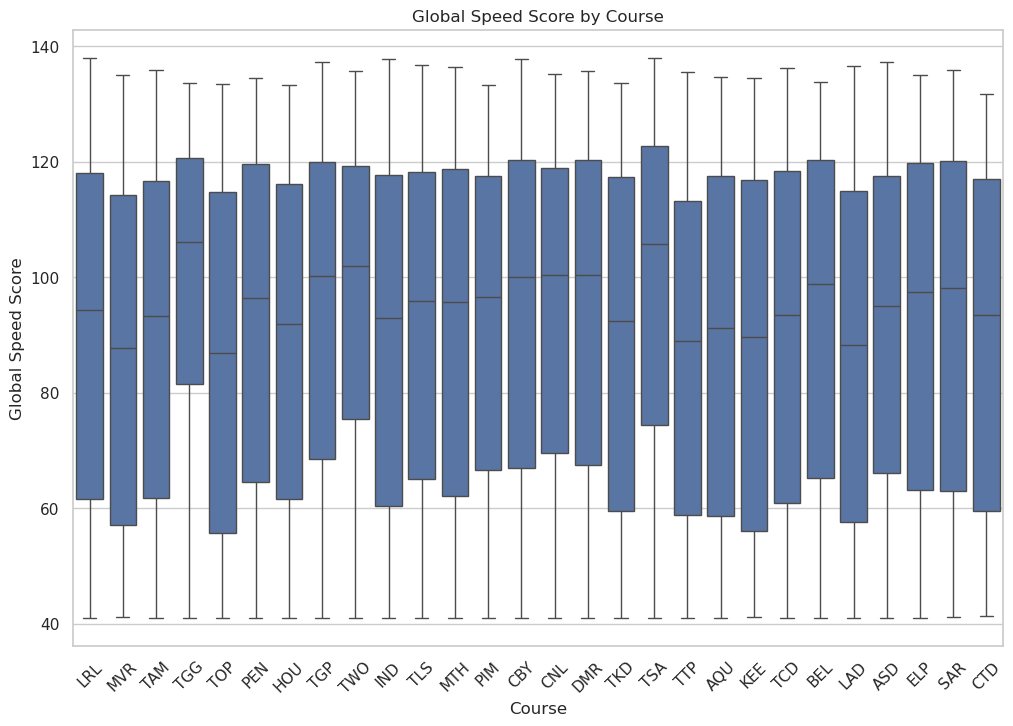

In [28]:

# 2. Boxplot of Global Speed Score by Course
plt.figure(figsize=(12,8))
sns.boxplot(x="course_cd", y="global_speed_score", data=full_df)
plt.title("Global Speed Score by Course")
plt.xlabel("Course")
plt.ylabel("Global Speed Score")
plt.xticks(rotation=45)
plt.show()

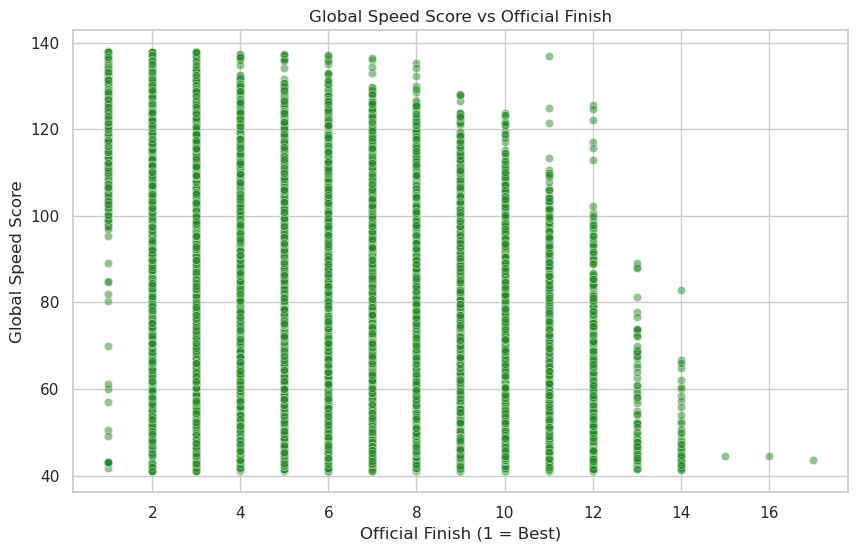

In [29]:

# 3. Scatter Plot: Global Speed Score vs. Official Finish
plt.figure(figsize=(10,6))
sns.scatterplot(x="official_fin", y="global_speed_score", data=full_df, alpha=0.5, color='forestgreen')
plt.title("Global Speed Score vs Official Finish")
plt.xlabel("Official Finish (1 = Best)")
plt.ylabel("Global Speed Score")
plt.show()


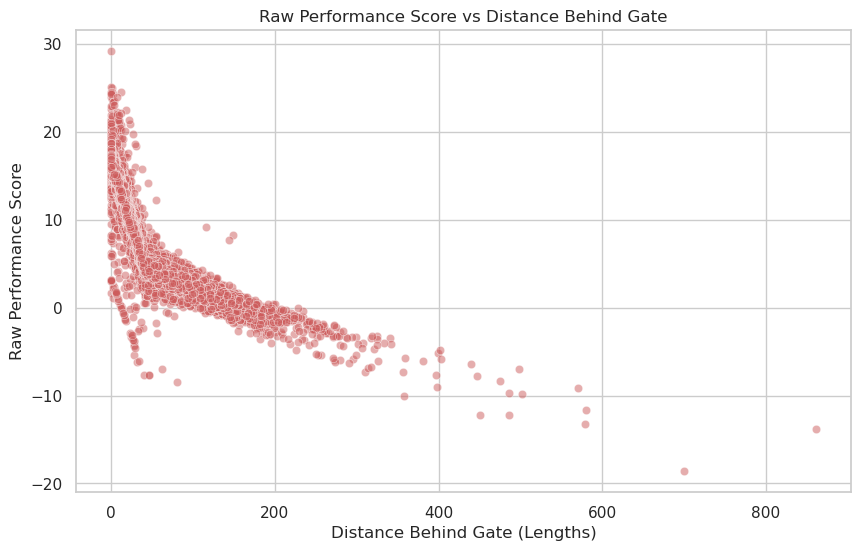

In [30]:
# 4. Scatter Plot: Raw Performance Score vs. Distance Behind Gate
plt.figure(figsize=(10,6))
sns.scatterplot(x="dist_bk_gate4", y="raw_performance_score", data=full_df, alpha=0.5, color='indianred')
plt.title("Raw Performance Score vs Distance Behind Gate")
plt.xlabel("Distance Behind Gate (Lengths)")
plt.ylabel("Raw Performance Score")
plt.show()

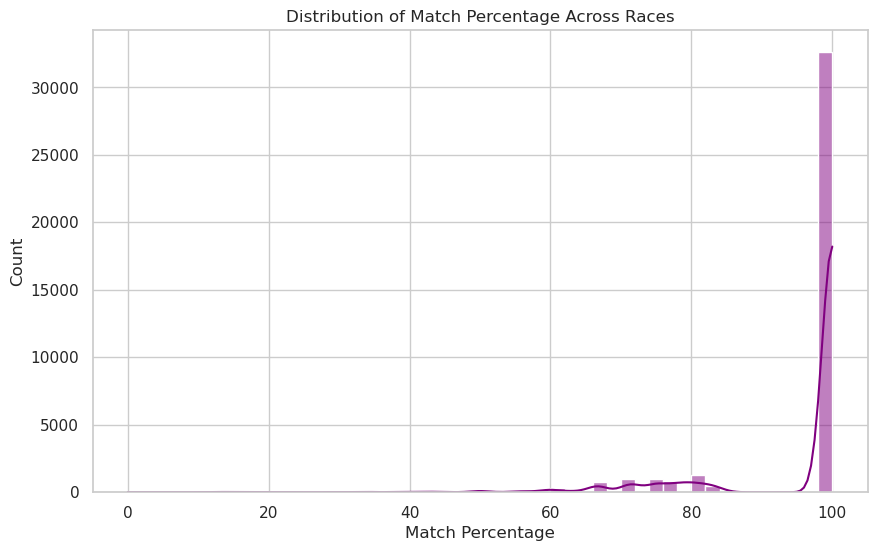

In [31]:

# 5. Distribution of Match Percentage Across Races
# (Assuming match_df is available from your earlier computation.)
if 'match_percentage' in match_df.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(match_df['match_percentage'], bins=50, kde=True, color='purple')
    plt.title("Distribution of Match Percentage Across Races")
    plt.xlabel("Match Percentage")
    plt.ylabel("Count")
    plt.show()
else:
    print("match_df does not have a 'match_percentage' column. Please check your match_df data.")


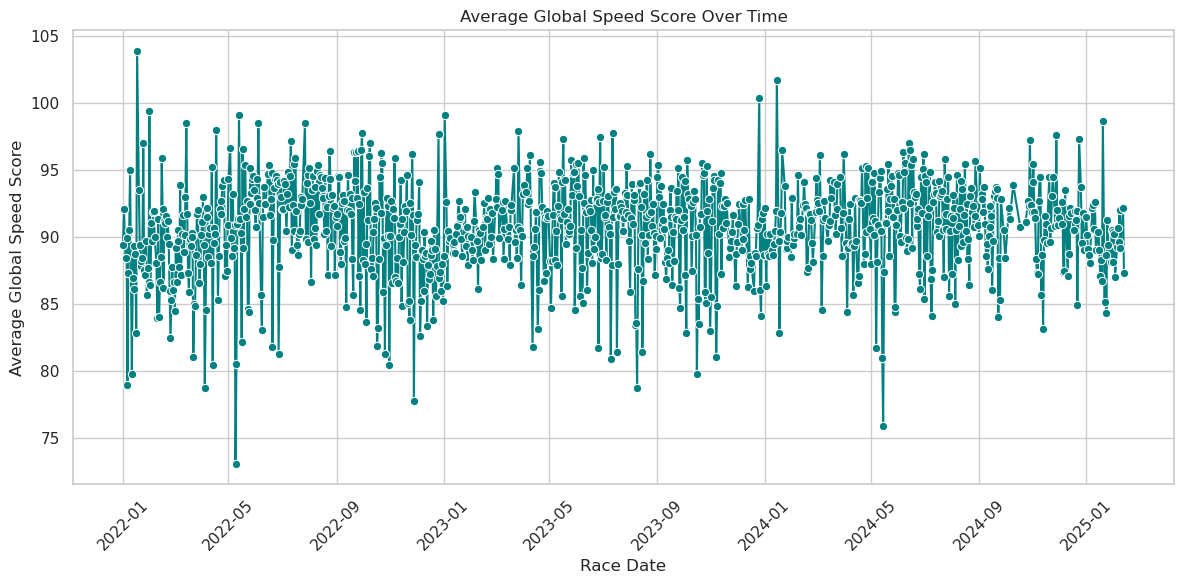

In [32]:
# 6. Time Series of Average Global Speed Score Over Race Dates
# Group by race_date and compute the average score
avg_speed_by_date = full_df.groupby("race_date")["global_speed_score"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="race_date", y="global_speed_score", data=avg_speed_by_date, marker="o", color='teal')
plt.title("Average Global Speed Score Over Time")
plt.xlabel("Race Date")
plt.ylabel("Average Global Speed Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()